# Analizando el modelo Sugarscape.
**A continuación se presenta un análisis de los datos arrojados por algunos experimentos realizados con el modelo de Sugarscape. Veremos la relación de la variable de dotación inicial (maximum-sugar-endowment y minimum-sugar-endowment) y las métricas del índice GINI, la cantidad de decesos por hambre (starvation), la riqueza per cápita y la cantidad promedio de cambios de azúcar tras aplicar las políticas de recaudación y redistribución. Los mapas de calor de cada experimentación pueden ser consultados a detalle en el otro notebook adjuntado.**
## Importando bibliotecas

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from pathlib import Path
sns.set()
carpeta_datasets= Path('datasets/')
ruta_resultados = 'comparativa_imagenes/'
#carpeta_datasets= Path('SinDisipacion/')
#ruta_resultados = 'no_disipados_imagenes/'

# Métodos auxiliares

In [4]:
def limpiar_dataframe(df):
    limpiado = df.drop(columns='visualization')
    limpiado = limpiado.drop(limpiado[limpiado['[step]'] == 0].index) # aquellas runs que no se iniciaron
    # aquellas runs invalidas
    limpiado = limpiado.drop(limpiado[limpiado['maximum-sugar-endowment'] <= limpiado['minimum-sugar-endowment']].index)
    limpiado = limpiado.drop(columns='[run number]')
    limpiado = limpiado.drop(columns='initial-population') #poblacion fija
    limpiado = limpiado.drop(columns='[step]') # en este punto, todas las runs son validas y llegaron a la it final
    return limpiado
    
def mapa_calor(df,medida,titulo,ruta):
    datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values=medida)
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(datos_aplanados, cmap='viridis',annot=False)
    plt.text(0, -0.5, titulo, fontsize=12, color='black', ha='left')
    plt.savefig(ruta,dpi=300, bbox_inches='tight')
    plt.show()
    

# Variables utiles

In [5]:
# Las diferentes implementaciones de politicas seran medidas segun su reduccion del
# indice gini, reduccion de decesos por hambruna, riqueza per capita mas alta y
# diferencias de riquezas menos marcadas
tipos_analisis = {'Indice Gini':'avg-gini',
                  'Riqueza per cápita':'avg-wealth',
                  'Diferencia de riquezas entre un tick y otro':'avg-diff',
                  'Decesos por hambruna' : 'starvation'
                 }
# Diccionario con listas de dataframes pivotados para su analisis
datos_analisis = {'Indice Gini': [],
                  'Riqueza per cápita': [],
                  'Diferencia de riquezas entre un tick y otro':[],
                  'Decesos por hambruna' : []
                 }
# Una lista donde se almacenaran los nombres de cada politica implementada
nombres_politicas = []

# Mapas de calor sobre el índice GINI, decesos por hambruna y riqueza per cápita

In [6]:
# Observando los resultados del modelo base sin politicas
datos_base = pd.read_csv('base/simple.csv')
datos_base = limpiar_dataframe(datos_base)
#for llave in tipos_analisis.keys():
    #mapa_calor(datos_base, tipos_analisis[llave], llave, 'figuras/'+llave)



## Cargando los datos arrojados por la implementación de diferentes politicas de recaudación redistribución
Los archivos siguen el patron recaudación-redistribución.csv

In [7]:

# patron util para recuperar el tipo de politica de recaudacion y redistribucion
patron = r"(\w+)-(\w+)\.csv$"
for archivo in carpeta_datasets.glob("*.csv"):
    # dataset correspondiende a la implementacion de una politica de recaudacion combinada con una de redistribucion
    df = pd.read_csv(archivo)
    df = limpiar_dataframe(df)
    match = re.match(patron, archivo.name)
    if match:
        print('cargando: ', archivo.name)
        # nombre de la politica de recaudacion y redistribucion
        recaudacion = match.group(1)
        redist = match.group(2)
        nombre = recaudacion +' '+ redist
        nombres_politicas.append(nombre)
        # dataframes pivotados para cada analisis(gini, riqueza, decesos, diferencias) de cada experimento
        for llave in tipos_analisis.keys():
            medida = tipos_analisis[llave]
            datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values=medida)
            datos_analisis[llave].append(datos_aplanados)
            


cargando:  lineal-dinamico.csv
cargando:  uniforme-dinamico.csv
cargando:  dinamico-uniforme.csv
cargando:  uniforme-lineal.csv
cargando:  lineal-uniforme.csv
cargando:  lineal-dirigidos.csv
cargando:  lineal-lineal.csv
cargando:  dinamico-dinamico.csv
cargando:  uniforme-uniforme.csv
cargando:  dinamico-lineal.csv


# Analizando los resultados
Ahora que ya tenemos los datos con las métricas arrojados por cada uno de los experimentos con las políticas, analicemos los mejores resultados 

## Metodos auxiliares

In [56]:
def menos_es_mejor(pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas bajo. 
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """

    base = pivotados[0].copy()
    etiquetas = pivotados[0].copy()
    etiquetas[~ etiquetas.isnull()] = 0
    base[~ base.isnull()] = float('inf')
        
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    mejor_valor = base.loc[idx,col]
                    politica_actual = pivotados[i]
                    valor_propuesto = politica_actual.loc[idx,col]
                    if valor_propuesto < mejor_valor:
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)
    
def mas_es_mejor(pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas alto. 
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """
    base = pivotados[0].copy()
    etiquetas = pivotados[0].copy()
    etiquetas[~ etiquetas.isnull()] = 0
    base[~ base.isnull()] = float('-inf')
    
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    politica_actual = pivotados[i]
                    valor_propuesto = politica_actual.loc[idx,col]
                    if valor_propuesto >= base.loc[idx,col] +1: # tolerancia
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)

def cercano_a_cero(pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas cercano a cero. 
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """
    base = pivotados[0].copy()
    etiquetas = pivotados[0].copy()
    etiquetas[~ etiquetas.isnull()] = 0
    base[~ base.isnull()] = float('inf')
        
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    mejor_valor = abs(base.loc[idx,col])
                    politica_actual = pivotados[i]
                    valor_propuesto = abs(politica_actual.loc[idx,col])
                    if valor_propuesto < mejor_valor:
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)


## Metodos auxiliares para representación visual

In [41]:
def representacion_visual(etiquetas, titulo, ruta):
    """
        Genera un mapa de calor para las etiquetas arrojadas por
        alguno de los metodos anteriores
    """
    cmap = sns.color_palette("hls", 10)
    # Creamos una máscara para los valores NaN
    mask = etiquetas.isna()
    
    plt.figure(figsize=(10, 8))
    
    # Generar el heatmap
    heatmap = sns.heatmap(etiquetas, annot=True, cmap=cmap, cbar=True, 
                      linewidths=0.5, linecolor='gray', mask=mask,
                      vmin=0, vmax=9)  # Establecemos los límites de la barra de colores

    # Color para los NaN
    heatmap.set_facecolor('lightgrey')
    # Personalizar la barra de colores
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks(np.arange(10))  # Aseguramos que haya 10 ticks (de 0 a 9)
    cbar.set_ticklabels([f"{i}: {nombres_politicas[i]}" for i in range(10)])  # Etiquetas personalizadas

    # Título y guardado del gráfico
    plt.title(titulo)
    plt.savefig(ruta, dpi=300, bbox_inches='tight')
    plt.show()

def mapa_resultados(resultados, titulo, ruta):
    """
        Genera un mapa de calor para los resultados arrojados por
        alguno de los metodos anteriores
    """
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(resultados, cmap='viridis',annot=False)
    plt.text(0, -0.5, titulo, fontsize=12, color='black', ha='left')
    plt.savefig(ruta,dpi=300, bbox_inches='tight')
    plt.show()

## Mejor politica para reducir el indice Gini segun el rango de riqueza inicial

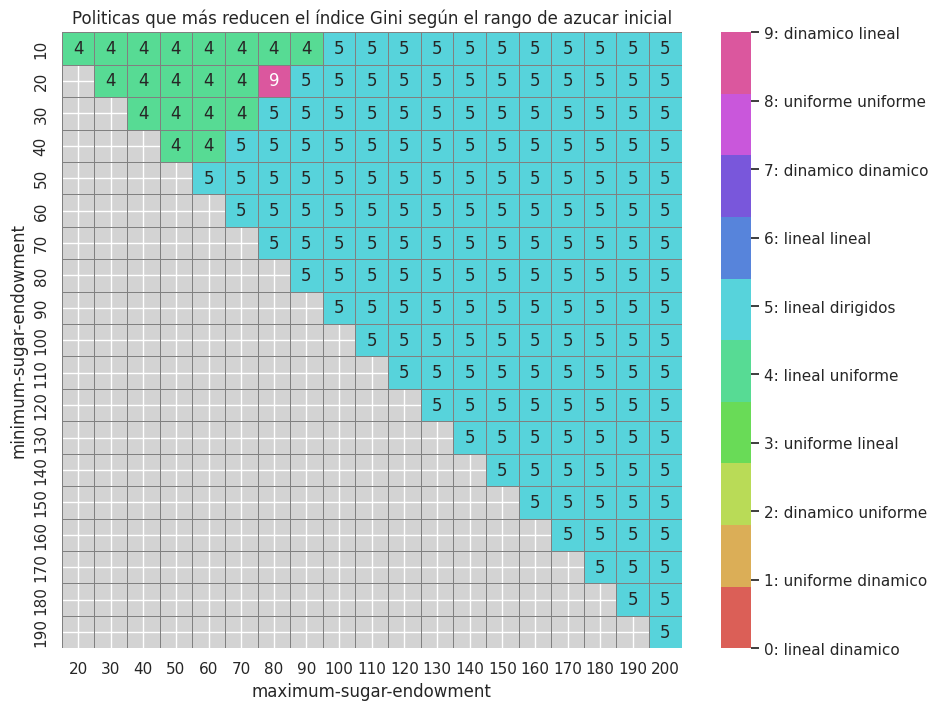

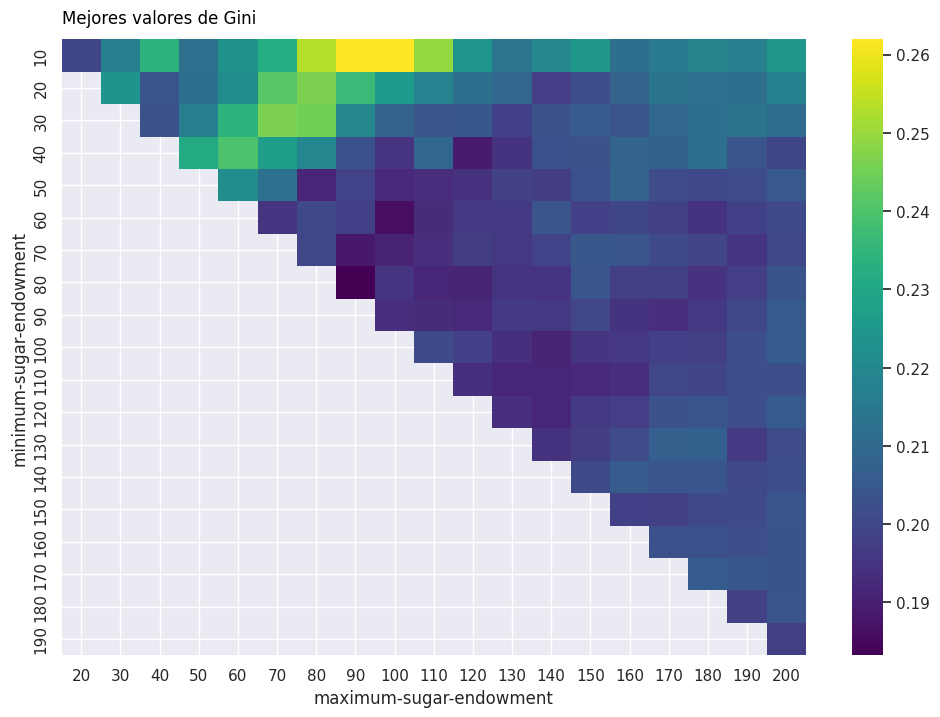

In [50]:
# Los valores base del indice gini del modelo sin politicas
pivotados_gini = datos_analisis['Indice Gini']
resultados, etiquetas = menos_es_mejor(pivotados_gini)
ruta = ruta_resultados + 'gini_politicas'
representacion_visual(etiquetas,"Politicas que más reducen el índice Gini según el rango de azucar inicial", ruta)
ruta = ruta_resultados + 'mejores_gini'
mapa_resultados(resultados,"Mejores valores de Gini",ruta)

## Mejor politica para reducir los decesos por hambruna

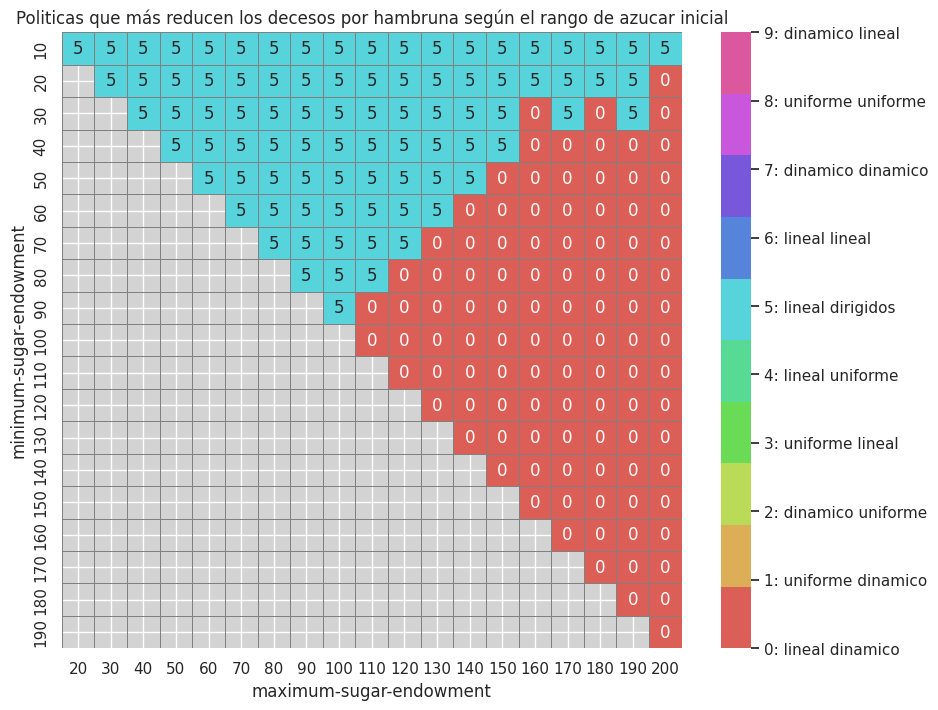

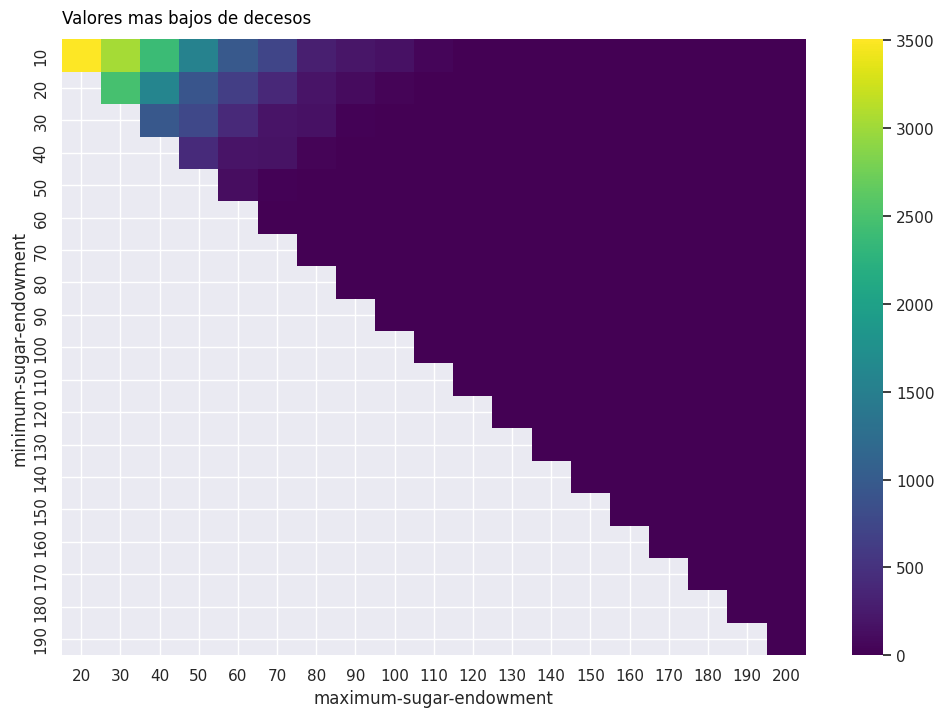

In [51]:
pivotados_starv= datos_analisis['Decesos por hambruna']
resultados, etiquetas = menos_es_mejor(pivotados_starv)
ruta = ruta_resultados + 'decesos_politicas'
representacion_visual(etiquetas,"Politicas que más reducen los decesos por hambruna según el rango de azucar inicial",ruta)
ruta = ruta_resultados + 'decesos_bajos'
mapa_resultados(resultados, "Valores mas bajos de decesos", ruta)

## Mejor politica para maximizar la riqueza per cápita

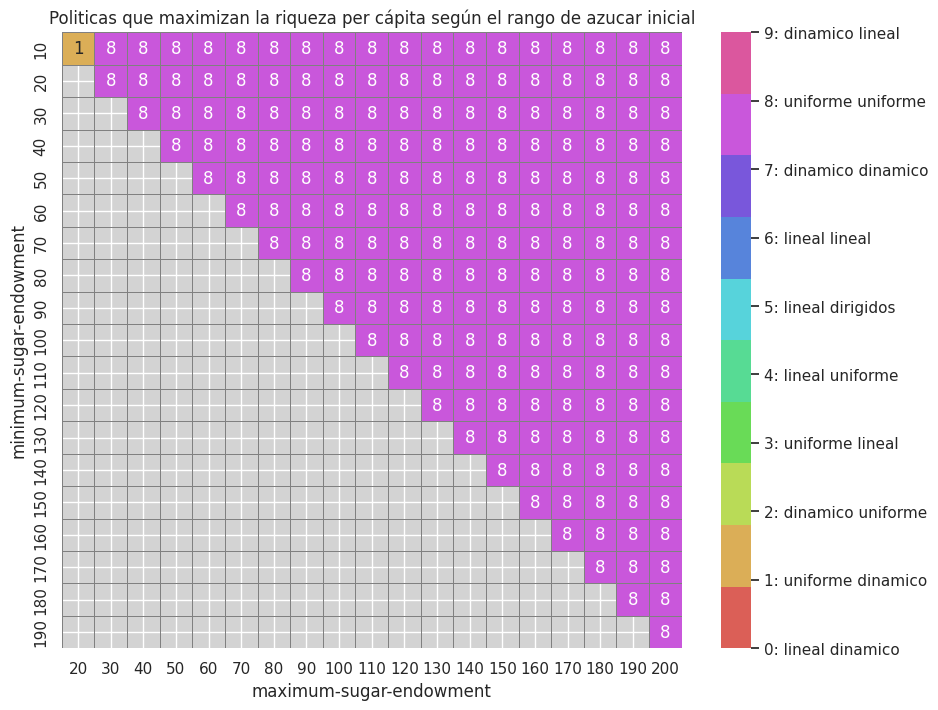

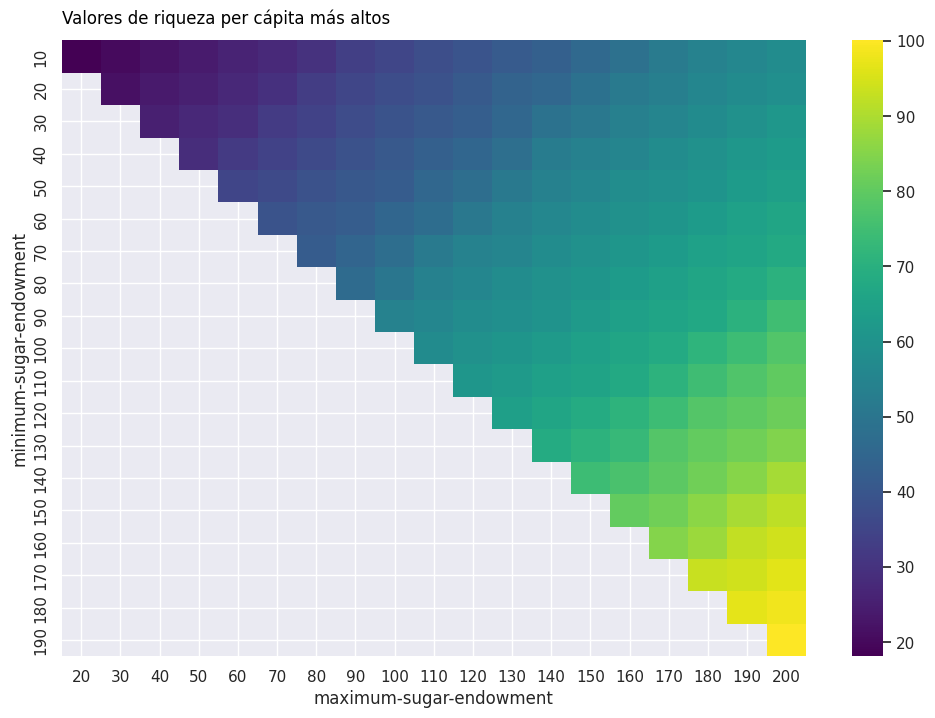

In [52]:
pivotados_riqueza = datos_analisis['Riqueza per cápita']
resultados, etiquetas = mas_es_mejor(pivotados_riqueza)
ruta = ruta_resultados + 'riquezas_politicas'
representacion_visual(etiquetas,"Politicas que maximizan la riqueza per cápita según el rango de azucar inicial",ruta)
ruta = ruta_resultados + 'riquezas_altas'
mapa_resultados(resultados,"Valores de riqueza per cápita más altos",ruta)

## Mejor política para minimizar los cambios de azúcar de un tick a otro

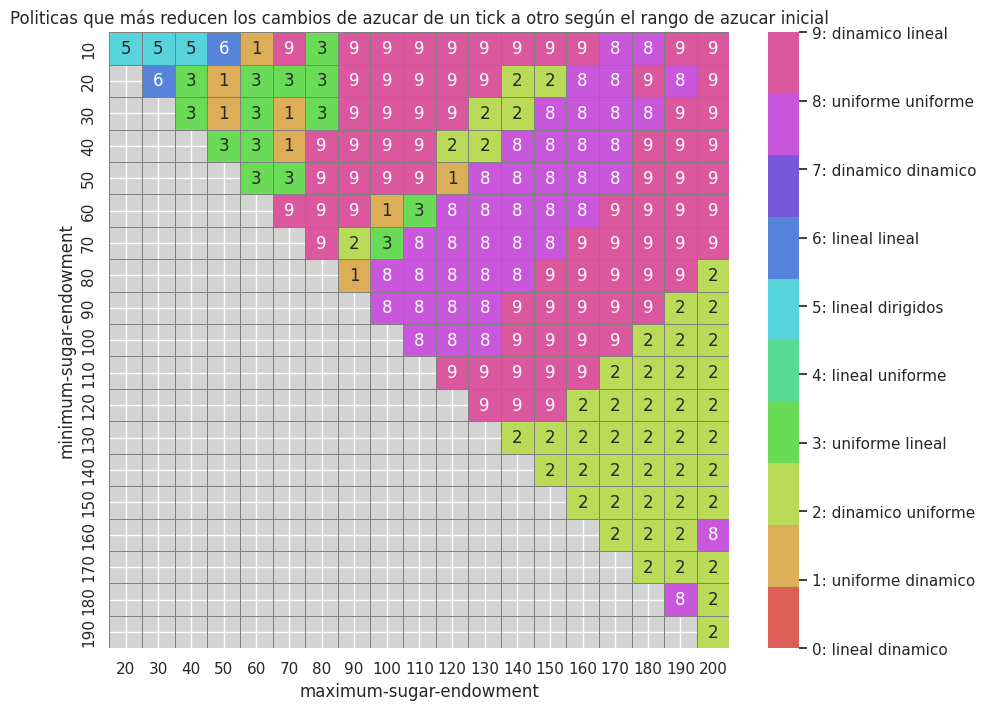

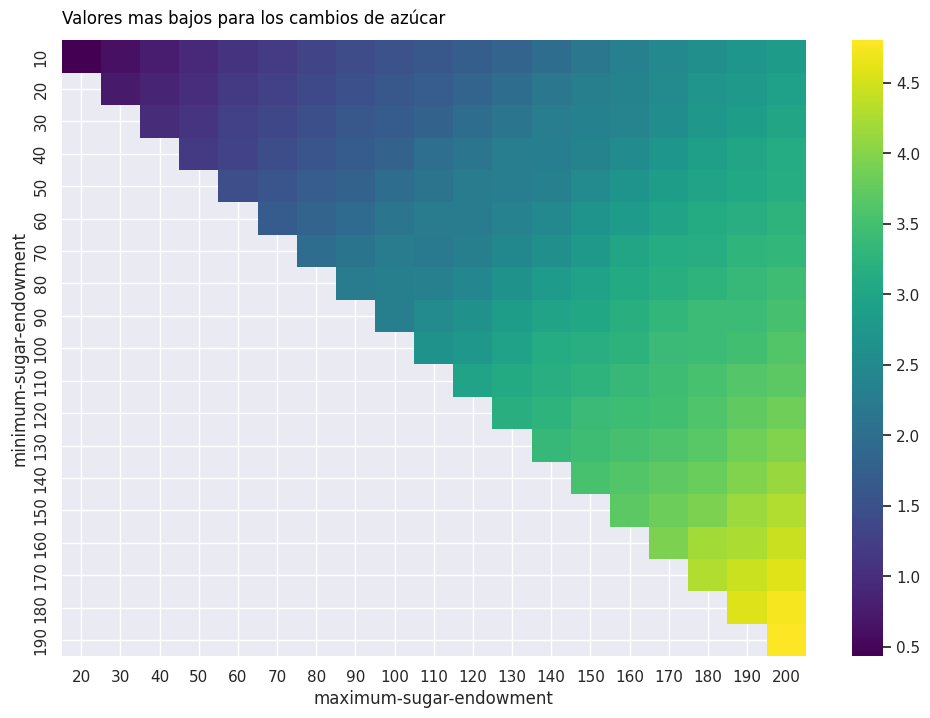

In [54]:
pivotados_diferencia = datos_analisis['Diferencia de riquezas entre un tick y otro']
resultados, etiquetas = cercano_a_cero(pivotados_diferencia)
ruta = ruta_resultados + 'cambios_azucar_politicas'
representacion_visual(etiquetas,"Politicas que más reducen los cambios de azucar de un tick a otro según el rango de azucar inicial",ruta)
ruta = ruta_resultados + 'cambios_minimos'
mapa_resultados(resultados,"Valores mas bajos para los cambios de azúcar", ruta)